# Task1 :Data preparation 

This section is dedicated to preparing the data in the TFRecord format

In [2]:
import os
import tensorflow as tf
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob



**Step 1:Helper Functions for TFRecord Features**


These functions convert data into a format suitable for TensorFlow's efficient data handling and storage.

In [3]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

**Step 3: Serializing Data into TFRecord Format**

This step involves the serialization of image data along with its metadata into a format that is compatible with TensorFlow's TFRecord.

In [4]:
def serialize_example(image_path, label):
    """
Serializes image data and labels into a format compatible with TFRecord for TensorFlow processing.

This function reads an image file from the specified path, encoding it in JPEG format, and retrieves its dimensions. 
It then constructs a feature dictionary that maps various attributes of the image (such as width, height, filename, and encoded data) 
and its annotations (like class label and image characteristics) to TensorFlow's compatible data types using helper functions. 
These attributes are encapsulated into a tf.train.Example message.

Parameters:

image_path: A string representing the path to the image file to be serialized.
label: An integer representing the label of the image.

Returns:

A serialized string of the tf.train.Example message, ready to be written into a TFRecord file.
This serialized format optimizes the storage and processing of large datasets in TensorFlow.
"""
    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_jpg = fid.read()
    image = Image.open(io.BytesIO(encoded_jpg))
    width, height = image.size

    feature = {
        "image/width": _int64_feature(width),
        "image/height": _int64_feature(height),
        'image/filename': _bytes_feature(tf.compat.as_bytes(os.path.basename(image_path))),
        'image/source_id': _bytes_feature(tf.compat.as_bytes(os.path.basename(image_path))),
        'image/encodedrawdata': _bytes_feature(encoded_jpg),
        'image/format': _bytes_feature(b'jpeg'),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'placeholder'])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[1])),
        'image/object/class/single': _int64_feature(1),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'Frontal'])),
         'image/object/class/label': _int64_feature(label),

    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


**Step 4: Write TFRecord Files**

In [5]:
# Define a mapping from directory names to unique integer labels
label_map = {
    'crazing': 0,
    'inclusion': 1,
    'patches': 2,
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}



In [6]:
def write_tfrecords_for_dataset(data_dir, output_dir):
    """
Creates TFRecord files for each image in a dataset, organized by category, and writes them to a specified output directory.

This function scans each category in the dataset, as defined by label_map, processing all images (PNG, JPG, JPEG). 
It serializes each image into a TFRecord by invoking serialize_example with the image's path and label, then writes each to a TFRecord file named after its category and image name.
It counts and reports the total images processed.

Parameters:

data_dir: The root directory where the dataset is stored, structured by category folders.
output_dir: The directory where the resulting TFRecord files will be written.

This approach enables the efficient storage and access of image data and labels,
facilitating the use of TensorFlow for deep learning model training and evaluation.
"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    total_images = 0   # Initialize total_images before the loop
    for category in label_map.keys():
        category_path = os.path.join(data_dir, category)
        images = [img for img in os.listdir(category_path) if img.lower().endswith('jpg')]
        total_images += len(images)  # Accumulate the count of images
        
        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            tfrecord_filename = os.path.join(output_dir, f"{category}_{image_name}.tfrecord")
            label = label_map[category]  # Get the label for the category
            serialized_example = serialize_example(image_path, label)
            
            with tf.io.TFRecordWriter(tfrecord_filename) as writer:
                writer.write(serialized_example)
    
    print(f"Total {total_images} images found and processed in {data_dir}")
    print(f"TFRecord files written to {output_dir}")

**Step 5: Setting Up Dataset Directories for Training and Testing**

In [7]:
train_data_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/images'
test_data_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images'

****Output directories for TFRecords****

In [8]:

train_output_dir = '/kaggle/working/train_tfrecords'
test_output_dir = '/kaggle/working/test_tfrecords'


**Step 6: Generate TFRecords**

In [9]:
write_tfrecords_for_dataset(train_data_dir, train_output_dir)
write_tfrecords_for_dataset(test_data_dir, test_output_dir)

Total 1440 images found and processed in /kaggle/input/neu-surface-defect-database/NEU-DET/train/images
TFRecord files written to /kaggle/working/train_tfrecords
Total 360 images found and processed in /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images
TFRecord files written to /kaggle/working/test_tfrecords


In [10]:
!ls /kaggle/working/test_tfrecords | head


crazing_crazing_241.jpg.tfrecord
crazing_crazing_242.jpg.tfrecord
crazing_crazing_243.jpg.tfrecord
crazing_crazing_244.jpg.tfrecord
crazing_crazing_245.jpg.tfrecord
crazing_crazing_246.jpg.tfrecord
crazing_crazing_247.jpg.tfrecord
crazing_crazing_248.jpg.tfrecord
crazing_crazing_249.jpg.tfrecord
crazing_crazing_250.jpg.tfrecord
ls: write error: Broken pipe


**Parsing and Decoding single TFRecosrd example into an image**


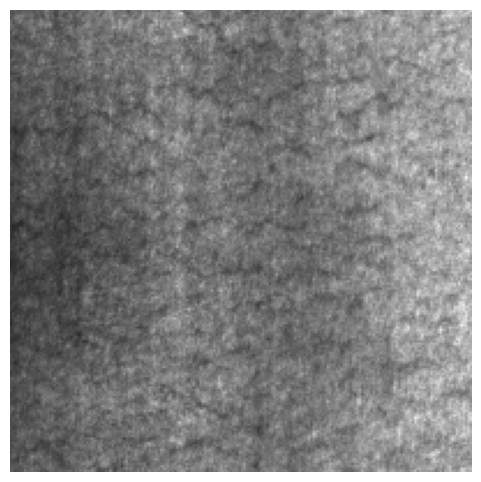

In [11]:

def parse_tfrecord(tfrecord):
    """
Decodes a single TFRecord example into an image.

This function extracts and decodes the JPEG image data from a TFRecord example based on a predefined schema. 
The schema specifies that each TFRecord contains an 'image/encodedrawdata' feature, which is a string-encoded JPEG image.
The function decodes this string back into a 3-channel RGB image tensor suitable for further processing or model input.

Parameters:

tfrecord: The serialized TFRecord example to parse.

Returns:

A tensor representing the decoded JPEG image.
"""
    feature_description = {
        "image/encodedrawdata": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    return image

# Reading TFRecord files
raw_dataset = tf.data.TFRecordDataset(['/kaggle/working/train_tfrecords/crazing_crazing_8.jpg.tfrecord'])
for raw_record in raw_dataset.take(1):
    image = parse_tfrecord(raw_record)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()



**Label Extraction and Verification from TFRecord Files**

In [12]:
def read_and_print_label_from_tfrecord(tfrecord_file):
    """
Reads and prints the label from a TFRecord file.

Processes and prints labels from a TFRecord file, which is expected to include 'image/encodedrawdata' and 'image/object/class/label'.
It converts the file into a dataset, parses it using a defined structure, and prints each extracted label.
Useful for content verification or debugging.

Parameters:

tfrecord_file: The path to the TFRecord file to be read.
  """
    raw_dataset = tf.data.TFRecordDataset([tfrecord_file])

    # Define feature structure
    feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }

    def _parse_function(example_proto):
        # Parse the input `tf.train.Example` proto using the feature description.
        return tf.io.parse_single_example(example_proto, feature_description)

    for parsed_record in raw_dataset.map(_parse_function):
        label = parsed_record['image/object/class/label'].numpy()
        print(f"Label: {label}")

# Example usage
tfrecord_to_check = '/kaggle/working/train_tfrecords/scratches_scratches_67.jpg.tfrecord'#expected result : 5 
read_and_print_label_from_tfrecord(tfrecord_to_check)

Label: 5


**Gathering TFRecord Files for Training and Testing Sets**

Used glob.glob to expand the wildcard pattern to a list of TFRecord files

In [13]:
train_tfrecord_files = glob.glob('/kaggle/working/train_tfrecords/*.tfrecord')
test_tfrecord_files = glob.glob('/kaggle/working/test_tfrecords/*.tfrecord')
# Verify that files are found
print(f"Found {len(train_tfrecord_files)} training TFRecord files")
print(f"Found {len(test_tfrecord_files)} testing TFRecord files")


Found 1440 training TFRecord files
Found 360 testing TFRecord files


Download output data for later use 

In [ ]:
#!zip -r dataset.zip train_tfrecords test_tfrecords
